Linear Regression - Training R^2 score: 0.29311803484001375
Linear Regression - Testing R^2 score: 0.28180516389408483


c:\Users\mymai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mymai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mymai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mymai\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mymai\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA paramete

ARIMA - Mean Absolute Error (MAE): 0.5100426395424308


ValueError: x and y must be the same size

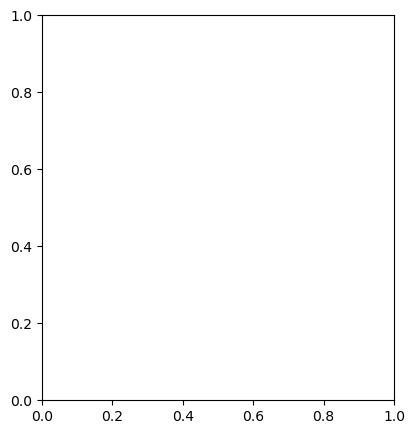

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import tkinter as tk
from tkinter import filedialog
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import os  # Add import statement for os module

# Create a Tkinter window
root = tk.Tk()
root.withdraw()  # Hide the root window

# Open a file dialog window
file_path = filedialog.askopenfilename(title="Select CSV file", filetypes=[("CSV files", "*.csv")])

# global declaration of numeric transformer.
numeric_transformer = StandardScaler()

# Check if a file was selected
if file_path:
    # Load the dataset
    df = pd.read_csv(file_path, encoding='latin1')
else:
    print("Error in reading the file. Please ensure correct format.")

def preprocess_data(data):
    # Drop categorical columns from the DataFrame
    categorical_columns = data.select_dtypes(include=['object']).columns
    df_numeric = data.drop(categorical_columns, axis=1)

    # Data cleaning for the 'price' column
    # Convert column names to lowercase for case-insensitive search
    df_columns_lower = [col.lower() for col in df_numeric.columns]

    # Check if "price" column exists in the DataFrame (case-insensitive)
    if 'price' in df_columns_lower:
        # Find the index of 'price' column
        price_index = df_columns_lower.index('price')
        
        # Perform preprocessing only on the 'price' column
        price_column = df_numeric.iloc[:, price_index:price_index+1]  # Extract 'price' column as DataFrame

        # Preprocess numeric features
        price_column_preprocessed = numeric_transformer.fit_transform(price_column)
        
        # Apply SimpleImputer to fill missing values in 'price' column with mean
        numeric_imputer = SimpleImputer(strategy='mean')
        price_column_preprocessed = numeric_imputer.fit_transform(price_column_preprocessed)
        
        # Replace original 'price' column with preprocessed values
        df_numeric.iloc[:, price_index:price_index+1] = price_column_preprocessed

    else:
        print("Column 'price' not found in the DataFrame.")

    return df_numeric


# Preprocess the data
preprocessed_df = preprocess_data(df)
preprocessed_df.columns = preprocessed_df.columns.str.lower()

# Split the data into features (X) and target variable (y)
X = preprocessed_df.drop(columns=['price'])  # Features
y = preprocessed_df['price']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reset index of X_test and y_test
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Train a linear regression model (optional, for comparison)
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the linear regression model (optional, for comparison)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print("Linear Regression - Training R^2 score:", train_score)
print("Linear Regression - Testing R^2 score:", test_score)

# Train an ARIMA model
# Assuming 'price' is our target variable and the data is time series data
# Example: ARIMA(p, d, q) where p is the order of the autoregressive part, d is the degree of differencing, and q is the order of the moving average part
model_arima = ARIMA(y_train, order=(6,2,1))
model_arima_fit = model_arima.fit()

# Forecast
forecast = model_arima_fit.forecast(steps=len(y_test))

# Evaluate the ARIMA model
mae_arima = mean_absolute_error(y_test, forecast)
print("ARIMA - Mean Absolute Error (MAE):", mae_arima)

# Plotting
plt.figure(figsize=(10, 5))

# Plot actual vs predicted for Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')
plt.title('Actual vs Predicted (Linear Regression)')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Plot actual vs forecasted for ARIMA
plt.subplot(1, 2, 2)
plt.scatter(y_test, forecast_arima, color='red')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')
plt.title('Actual vs Forecasted (ARIMA)')
plt.xlabel('Actual')
plt.ylabel('Forecasted')

plt.tight_layout()
plt.show()

# Predict using the linear regression model
y_pred_test = model.predict(X_test)
# Inverse transform the predicted prices from both models
y_pred_linear_original = numeric_transformer.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

# Convert the forecast Series to a NumPy array
forecast_array = forecast.to_numpy()

# Reshape the NumPy array
forecast_array_reshaped = forecast_array.reshape(-1, 1)

# Inverse transform the reshaped array
forecast_arima_original = numeric_transformer.inverse_transform(forecast_array_reshaped).flatten()
# Repeat each value in the forecast array to match the length of the index
output_df = pd.DataFrame({'LinearRegression_Predictions_Price': y_pred_linear_original,'ARIMA_Forecasts_Price': forecast_arima_original})

# Specify the directory and filename for the output file
output_directory = 'C://Users/mymai/Downloads'
output_filename = 'predictions.csv'
output_file = os.path.join(output_directory, output_filename)

# Save the DataFrame to the specified CSV file
output_df.to_csv(output_file, index=False)

print("File saved at:", output_file)




c:\Users\mymai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mymai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mymai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mymai\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mymai\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA paramete

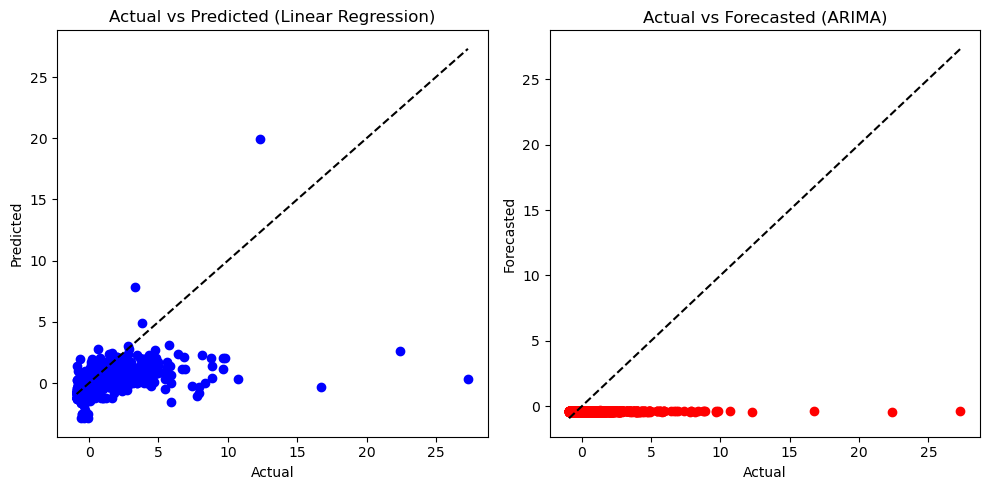

File saved at: C://Users/mymai/Downloads\predictions2.csv


In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import tkinter as tk
from tkinter import filedialog
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import os  

# Create a Tkinter window
root = tk.Tk()
root.withdraw()  # Hide the root window

# Open a file dialog window
file_path = filedialog.askopenfilename(title="Select CSV file", filetypes=[("CSV files", "*.csv")])

# Global declaration of numeric transformer.
numeric_transformer = StandardScaler()

# Check if a file was selected
if file_path:
    # Load the dataset
    df = pd.read_csv(file_path, encoding='latin1')
else:
    print("Error in reading the file. Please ensure correct format.")

def preprocess_data(data):
    # Drop categorical columns from the DataFrame
    categorical_columns = data.select_dtypes(include=['object']).columns
    df_numeric = data.drop(categorical_columns, axis=1)

    # Data cleaning for the 'price' column
    # Convert column names to lowercase for case-insensitive search
    df_columns_lower = [col.lower() for col in df_numeric.columns]

    # Check if "price" column exists in the DataFrame (case-insensitive)
    if 'price' in df_columns_lower:
        # Find the index of 'price' column
        price_index = df_columns_lower.index('price')
        
        # Perform preprocessing only on the 'price' column
        price_column = df_numeric.iloc[:, price_index:price_index+1]  # Extract 'price' column as DataFrame

        # Preprocess numeric features
        price_column_preprocessed = numeric_transformer.fit_transform(price_column)
        
        # Apply SimpleImputer to fill missing values in 'price' column with mean
        numeric_imputer = SimpleImputer(strategy='mean')
        price_column_preprocessed = numeric_imputer.fit_transform(price_column_preprocessed)
        
        # Replace original 'price' column with preprocessed values
        df_numeric.iloc[:, price_index:price_index+1] = price_column_preprocessed

    else:
        print("Column 'price' not found in the DataFrame.")

    return df_numeric


# Preprocess the data
preprocessed_df = preprocess_data(df)
preprocessed_df.columns = preprocessed_df.columns.str.lower()

# Split the data into features (X) and target variable (y)
X = preprocessed_df.drop(columns=['price'])  # Features
y = preprocessed_df['price']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reset index of X_test and y_test
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Train a linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Train an ARIMA model
model_arima = ARIMA(y_train, order=(6,2,1))
model_arima_fit = model_arima.fit()

# Predict using the linear regression model
y_pred_lr = model_lr.predict(X_test)

# Predict using the ARIMA model
forecast = model_arima_fit.forecast(steps=len(y_test))

# Plotting
plt.figure(figsize=(10, 5))

# Plot actual vs predicted for Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')
plt.title('Actual vs Predicted (Linear Regression)')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Plot actual vs forecasted for ARIMA
plt.subplot(1, 2, 2)
plt.scatter(y_test, forecast, color='red')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')
plt.title('Actual vs Forecasted (ARIMA)')
plt.xlabel('Actual')
plt.ylabel('Forecasted')

plt.tight_layout()
plt.show()

# Extract 'price' column from the original DataFrame
price_column = preprocessed_df['price']

# Calculate correlation with all other features in the original DataFrame
correlation = preprocessed_df.corrwith(price_column)

# Sort the correlation values in descending order
sorted_correlation = correlation.sort_values(ascending=False)

# Extract the name of the feature with the second-highest correlation
second_highest_corr_feature = sorted_correlation.index[1]

# Extract the column with the second-highest correlation coefficient
second_highest_corr_column = preprocessed_df[second_highest_corr_feature]


# Inverse transform the predicted prices from both models
y_pred_linear_original = numeric_transformer.inverse_transform(y_pred_lr.reshape(-1, 1)).flatten()

# Convert the forecast Series to a NumPy array
forecast_array = forecast.to_numpy()

# Reshape the NumPy array
forecast_array_reshaped = forecast_array.reshape(-1, 1)

# Inverse transform the reshaped array
forecast_arima_original = numeric_transformer.inverse_transform(forecast_array_reshaped).flatten()

df_matched_length = preprocessed_df[:len(y_pred_linear_original)]

# Create the DataFrame
output_df = pd.DataFrame({
    'LinearRegression_Predictions_Price': y_pred_linear_original,
    'ARIMA_Forecasts_Price': forecast_arima_original,
    second_highest_corr_feature: second_highest_corr_column
}, index=df_matched_length.index)


# Specify the directory and filename for the output file
output_directory = 'C://Users/mymai/Downloads'
output_filename = 'predictions2.csv'
output_file = os.path.join(output_directory, output_filename)

# Save the DataFrame to the specified CSV file
output_df.to_csv(output_file, index=False)

print("File saved at:", output_file)


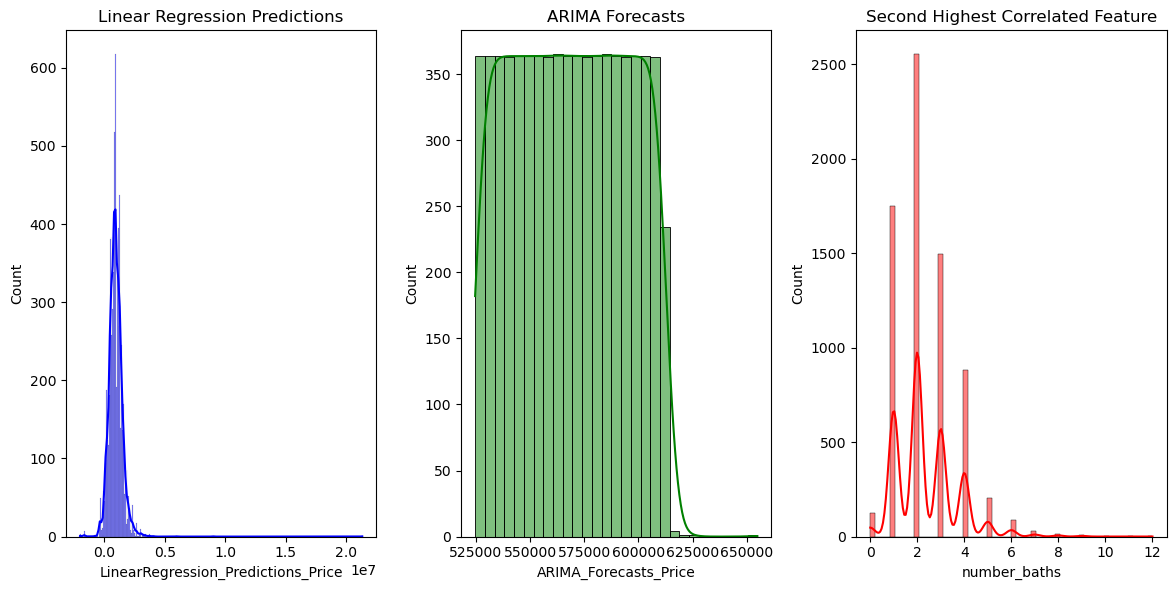

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for each feature
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.histplot(output_df['LinearRegression_Predictions_Price'], color='blue', kde=True)
plt.title('Linear Regression Predictions')

plt.subplot(1, 3, 2)
sns.histplot(output_df['ARIMA_Forecasts_Price'], color='green', kde=True)
plt.title('ARIMA Forecasts')

plt.subplot(1, 3, 3)
sns.histplot(output_df[second_highest_corr_feature], color='red', kde=True)
plt.title('Second Highest Correlated Feature')

plt.tight_layout()
plt.show()


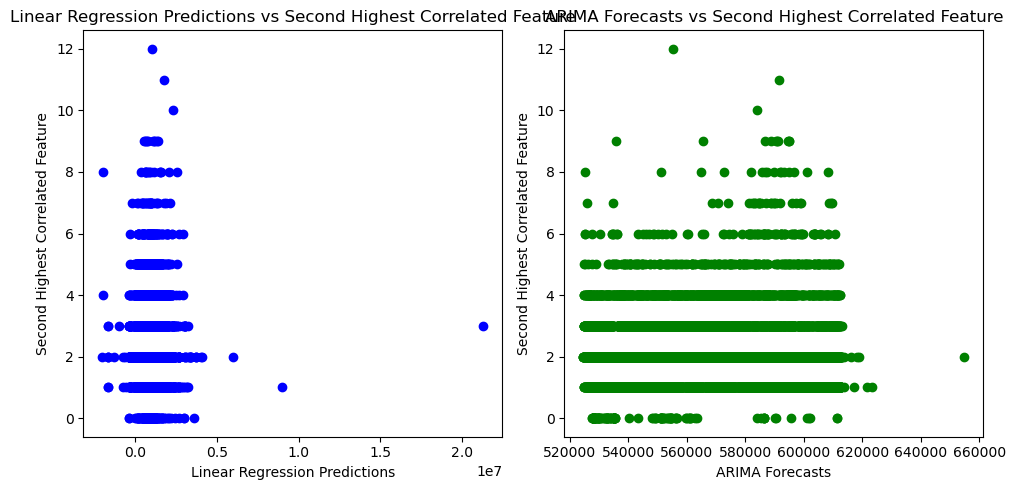

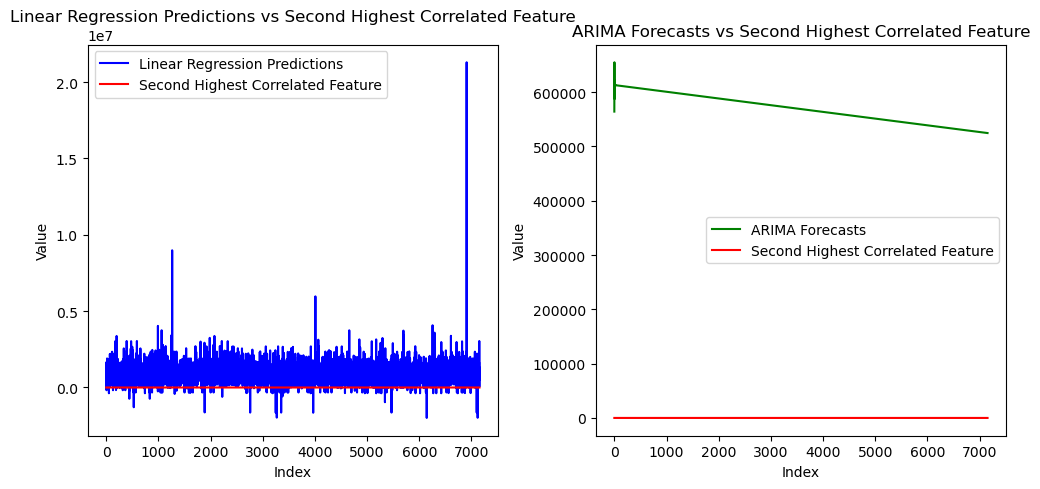

In [24]:
import matplotlib.pyplot as plt

# Create scatter plots
plt.figure(figsize=(10, 5))

# Scatter plot for Linear Regression predictions vs second highest correlated feature
plt.subplot(1, 2, 1)
plt.scatter(output_df['LinearRegression_Predictions_Price'], output_df[second_highest_corr_feature], color='blue')
plt.title('Linear Regression Predictions vs Second Highest Correlated Feature')
plt.xlabel('Linear Regression Predictions')
plt.ylabel('Second Highest Correlated Feature')

# Scatter plot for ARIMA forecasts vs second highest correlated feature
plt.subplot(1, 2, 2)
plt.scatter(output_df['ARIMA_Forecasts_Price'], output_df[second_highest_corr_feature], color='green')
plt.title('ARIMA Forecasts vs Second Highest Correlated Feature')
plt.xlabel('ARIMA Forecasts')
plt.ylabel('Second Highest Correlated Feature')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))

# Line chart for Linear Regression predictions vs second highest correlated feature
plt.subplot(1, 2, 1)
plt.plot(output_df['LinearRegression_Predictions_Price'], color='blue', label='Linear Regression Predictions')
plt.plot(output_df[second_highest_corr_feature], color='red', label='Second Highest Correlated Feature')
plt.title('Linear Regression Predictions vs Second Highest Correlated Feature')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Line chart for ARIMA forecasts vs second highest correlated feature
plt.subplot(1, 2, 2)
plt.plot(output_df['ARIMA_Forecasts_Price'], color='green', label='ARIMA Forecasts')
plt.plot(output_df[second_highest_corr_feature], color='red', label='Second Highest Correlated Feature')
plt.title('ARIMA Forecasts vs Second Highest Correlated Feature')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()
